In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [355]:
data = pd.read_csv('Data/dataset_mood_smartphone.csv')

In [302]:
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value,date,target
time,,,,,,,
2014-02-26 13:00:00,1,AS14.01,2014-02-26 13:00:00,mood,6.0,2014-02-26,6.250000
2014-02-26 15:00:00,2,AS14.01,2014-02-26 15:00:00,mood,6.0,2014-02-26,6.250000
2014-02-26 18:00:00,3,AS14.01,2014-02-26 18:00:00,mood,6.0,2014-02-26,6.250000
2014-02-26 21:00:00,4,AS14.01,2014-02-26 21:00:00,mood,7.0,2014-02-26,6.250000
2014-02-27 09:00:00,5,AS14.01,2014-02-27 09:00:00,mood,6.0,2014-02-27,6.333333


In [256]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


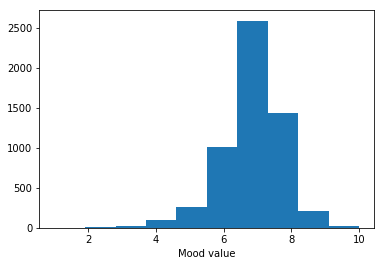

In [257]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


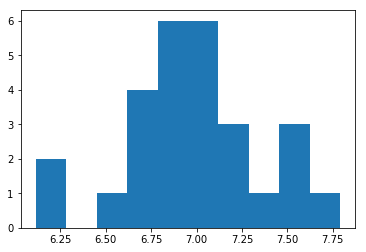

In [356]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()



In [97]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))
def compare_two_dates(date1, date2):
   
    if (date1[:4])>(date2[:4]):
        return date1
    elif (date1[:4])<(date2[:4]):
        return date2
    elif (date1[5:7])>(date2[5:7]):
            return date1
    elif (date1[5:7])<(date2[5:7]):
        return date2
    elif (date1[8:])>(date2[8:]):
        return date1
    elif (date1[8:])<(date2[8:]):
        return date2
    else: 
        return "same"
dates = get_date(data)[:2]
bigger_date = compare_two_dates(dates.iloc(0)[0][0], dates.iloc(1)[0][0])
print(bigger_date)



same


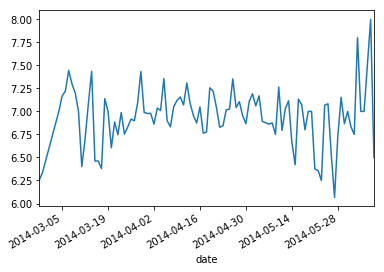

In [359]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. 
Mood = average per day, average for t days
circumplex.arousal = average
circumplex.valence = average
activity = average per day
screen = sum per day,  average along several days, sum along days
call = sum per day, average along several days, sum along days
sms = sum per day, average along several days, sum along days
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day. 
 
 Also days which are closer to t can be scored higher
 

In [463]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()
#target at day is the same as mood at day
date_data['target'] =date_data['mood']
#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)
#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
date_data.fillna(value=values0, inplace=True)
#to do : think about values he didn't fill yet. although we have xgboost, so shouldn't be a problem

mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000           -0.250000            0.750000   
        2014-02-27  6.333333            0.000000            0.333333   
        2014-03-21  6.200000            0.200000            0.200000   
        2014-03-22  6.400000            0.600000            0.500000   
        2014-03-23  6.800000            0.200000            0.800000   
        2014-03-24  6.000000            0.800000            0.000000   
        2014-03-25  6.750000            0.500000            0.500000   
        2014-03-26  6.600000           -0.200000            0.600000   
        2014-03-27  7.000000            0.200000            0.800000   
        2014-03-28  6.400000           -0.600000            0.600000   
        2014-03-29  8.000000            0.200000            1.000000   
        2014-03-30  7.500000           -0.500000            0.750000   
        2014-03-31  7.400000            0.000000            0.600000   
        2014-04-01  6.000000            0.200000            0.000000   
        2014-04-02  6.500000            0.333333            0.666667   
        2014-04-03  6.400000           -1.200000            0.000000   
        2014-04-04  6.200000            0.200000            0.400000   
        2014-04-05  6.800000           -0.400000            0.600000   
        2014-04-06  6.500000           -0.750000            0.500000   
        2014-04-07  6.500000           -0.666667            0.250000   
        2014-04-08  6.600000           -0.400000            0.333333   
        2014-04-09  7.400000           -0.800000            1.000000   
        2014-04-10  7.400000           -0.400000            0.800000   
        2014-04-11  7.000000           -1.200000            0.800000   
        2014-04-12  7.250000           -0.750000            0.750000   
        2014-04-13  8.000000           -1.250000            1.000000   
        2014-04-14  7.200000           -1.200000            0.600000   
        2014-04-15  6.400000            0.000000            0.800000   
        2014-04-16  7.200000            0.750000            0.500000   
        2014-04-17  6.600000           -0.400000            0.600000   
...                      ...                 ...                 ...   
AS14.25 2014-03-03       NaN                 NaN                 NaN   
        2014-03-13       NaN                 NaN                 NaN   
        2014-03-28       NaN                 NaN                 NaN   
        2014-03-31       NaN                 NaN                 NaN   
        2014-04-04       NaN                 NaN                 NaN   
        2014-04-06       NaN                 NaN                 NaN   
AS14.26 2014-02-22       NaN                 NaN                 NaN   
AS14.27 2014-02-20       NaN                 NaN                 NaN   
        2014-03-08       NaN                 NaN                 NaN   
        2014-03-10       NaN                 NaN                 NaN   
AS14.29 2014-02-19       NaN                 NaN                 NaN   
        2014-02-22       NaN                 NaN                 NaN   
AS14.30 2014-02-22       NaN                 NaN                 NaN   
        2014-03-12       NaN                 NaN                 NaN   
AS14.31 2014-03-10       NaN                 NaN                 NaN   
        2014-03-14       NaN                 NaN                 NaN   
AS14.32 2014-02-19       NaN                 NaN                 NaN   
AS14.33 2014-02-27       NaN                 NaN                 NaN   
        2014-03-26       NaN                 NaN                 NaN   
        2014-03-28       NaN                 NaN                 NaN   
        2014-03-29       NaN                 NaN                 NaN   
AS14.01 2014-02-21       NaN                 NaN                 NaN   
        2014-03-16       NaN                 NaN                

In [464]:
lag = 5
rolling_variables  = date_data.columns
for variable in rolling_variables:
    date_data["{}_lagged".format(variable)]=date_data[variable].rolling(window = lag).mean()

In [477]:
list_var = list(rolling_variables)
list_var.remove('target')
feature_data = np.array(date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =feature_data[:,1:], feature_data[:,0]



(1392,)

In [489]:
#!sudo pip3 install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
#missing data computation
df['rolling_sum_backfilled'] = df['rolling_sum'].fillna(method='backfill')
df.head(10)